# Rice Stress Preprocessing Development

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os


In [153]:
## Function to show image
def show_image(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

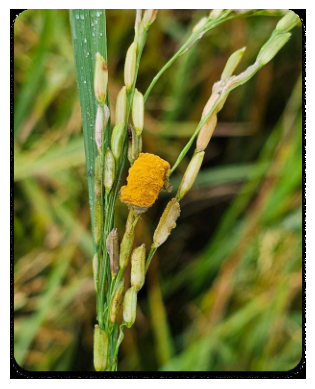

In [91]:
## Load image
def load_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

image = load_image('assets//false_smut.png')
show_image(image)

In [92]:
  
def canny_edge_detection(frame): 
    # Convert the frame to grayscale for edge detection 
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
      
    # Apply Gaussian blur to reduce noise and smoothen edges 
    blurred = cv2.GaussianBlur(src=gray, ksize=(5, 5), sigmaX=0.5) 
      
    # Perform Canny edge detection 
    edges = cv2.Canny(blurred, 150, 250) 
      
    return blurred, edges

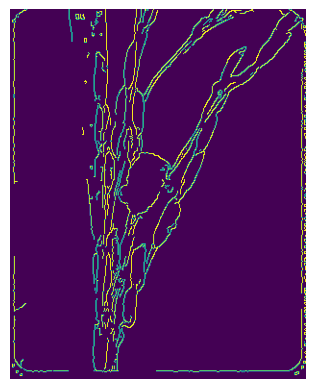

In [93]:
# Perform Canny edge detection on the frame 
blurred, edges = canny_edge_detection(image) 
show_image(edges)

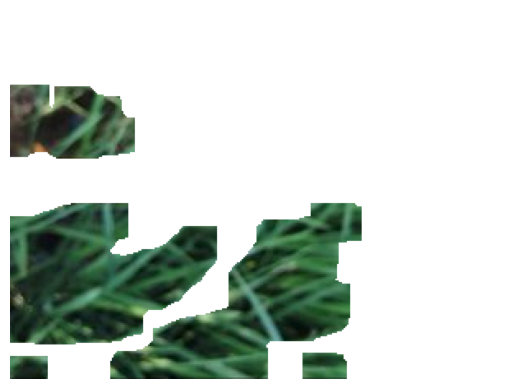

In [94]:
def bgremove3(myimage):
    # BG Remover 3
    myimage_hsv = cv2.cvtColor(myimage, cv2.COLOR_BGR2HSV)

    temp=[]
    for plane in cv2.split(myimage_hsv):
        proc = cv2.medianBlur(plane, 15)
        temp.append(proc)
    myimage_hsv = cv2.merge(temp)
     
    #Take S and remove any value that is less than half
    s = myimage_hsv[:,:,1]
    s = np.where(s < 127, 0, 1) # Any value below 127 will be excluded
 
    # We increase the brightness of the image and then mod by 255
    v = (myimage_hsv[:,:,2] + 127) % 255
    v = np.where(v > 127, 1, 0)  # Any value above 127 will be part of our mask
 
    # Combine our two masks based on S and V into a single "Foreground"
    foreground = np.where(s+v > 0, 1, 0).astype(np.uint8)  #Casting back into 8bit integer
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
    foreground = cv2.morphologyEx(foreground, cv2.MORPH_OPEN, kernel, iterations=5)
    show_image(foreground)
 
    background = np.where(foreground==0,255,0).astype(np.uint8) # Invert foreground to get background in uint8
    background = cv2.cvtColor(background, cv2.COLOR_GRAY2BGR)  # Convert background back into BGR space
    foreground=cv2.bitwise_and(myimage,myimage,mask=foreground) # Apply our foreground map to original image
    finalimage = background+foreground # Combine foreground and background
 
    return finalimage

show_image(bgremove3(image2))

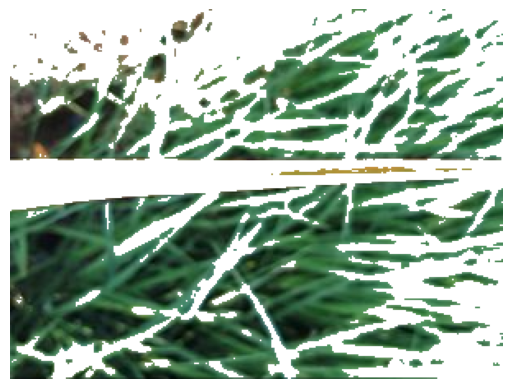

In [95]:
image2 = load_image('assets//tungro.jpg')
show_image(bgremove2(image2))

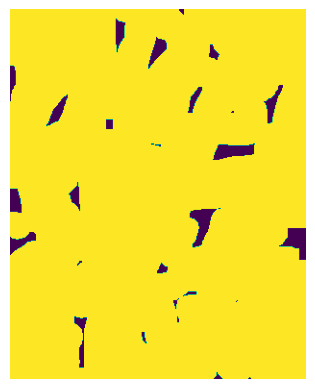

[[-1 -1 -1 -1]]


error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2537: error: (-215:Assertion failed) npoints > 0 in function 'cv::drawContours'


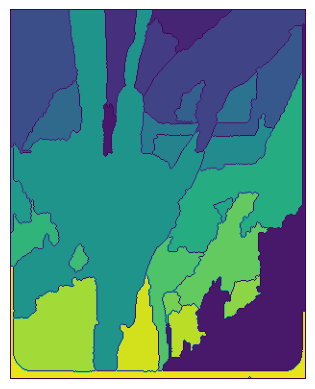

In [104]:

#Image loading 
img = image
orig_img = img.copy()
rgb_planes = cv2.split(img)
result_planes,result_norm_planes = [], []
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE()
for plane in rgb_planes:
    # processed_image = cv2.dilate(plane, (15, 15), 10) 
    processed_image = clahe.apply(plane)
    # processed_image= cv2.medianBlur(processed_image,5)
    # norm_processed_image = cv2.normalize(processed_image,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
    result_planes.append(processed_image)
    # result_norm_planes.append(norm_processed_image)

result = cv2.merge(result_planes)
# result_norm = cv2.merge(result_norm_planes)

#image grayscale conversion 
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY) 
# gray = hsv[:,:,1]

#Threshold Processing 
ret, bin_img = cv2.threshold(gray, 
                            0, 255,  
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 

# noise removal 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7, 7)) 
bin_img = cv2.morphologyEx(bin_img,  
                        cv2.MORPH_OPEN, 
                        kernel, 
                        iterations=2) 

# Create subplots with 1 row and 2 columns 
# sure background area 
sure_bg = cv2.dilate(bin_img, kernel, iterations=10) 
show_image(sure_bg)

# Distance transform 
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5) 
show_image(dist)

#foreground area 
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY) 
sure_fg = sure_fg.astype(np.uint8)   
show_image(sure_fg) 

# unknown area 
unknown = cv2.subtract(sure_bg, sure_fg) 
show_image(unknown)

plt.show()

# Marker labelling 
# sure foreground  
ret, markers = cv2.connectedComponents(sure_fg) 

# Add one to all labels so that background is not 0, but 1 
markers += 1
# mark the region of unknown with zero 
markers[unknown == 255] = 0

show_image(markers)


# watershed Algorithm 
markers = cv2.watershed(img, markers) 
 
show_image(markers)



labels = np.unique(markers) 

coins = [] 
# Iterate through the labels and process each one
for label in labels[2:]:
    # Create a binary image in which only the area of the label is in the foreground
    target = np.where(markers == label, 255, 0).astype(np.uint8)

    # Perform contour extraction on the created binary image
    _, contours = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Check if there are any contours found
    if contours.any():
        # Draw the outline for each contour
        for contour in contours:
            print(contour)
            img = cv2.drawContours(img, contour, -1, color=(0, 23, 223), thickness=2)

show_image(img)

# img = cv2.imread("jpgData\9\9F--46-_jpg.rf.a10da8c992871ddc643e74e0bbe30c94.jpg")[100:300,100:300,:]
# rgb_planes = cv2.split(img)
# result_planes=[]
# for plane in rgb_planes:
#     plane = plane * (markers > 1)
#     result_planes.append(plane)
# result_image = cv2.merge(result_planes)
# result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
# plt.show_image(result_image)

# result_hsv = cv2.cvtColor(result_image, cv2.COLOR_RGB2HSV)


# fig, ax = plt.subplots(1,3, figsize=(15,4))
# ax[0].show_image(result_hsv[:,:,0]) #hue
# ax[0].set_title("HUE")
# ax[1].show_image(result_hsv[:,:,1]) #saturation
# ax[1].set_title("SATURATION")
# ax[2].show_image(result_hsv[:,:,2]) #value
# ax[2].set_title("VALUE")
# fig.suptitle("HSV Image")
# plt.show()

# Get unique labels/markers (excluding background and unknown)
unique_labels = np.unique(markers)[2:]

# Create a directory to save the extracted region images
# if not os.path.exists("segmented_regions"):
#     os.mkdir("segmented_regions")

# Extract and preprocess each segmented region
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
for label in unique_labels:
    # Create a binary mask for the specific label
    region_mask = np.where(markers == label, 255, 0).astype(np.uint8)

    # Apply the mask to the original image to extract the region
    region = cv2.bitwise_and(orig_img, orig_img, mask=region_mask)

    # # Find the bounding box coordinates (non-zero pixels)
    non_zero_coords = np.argwhere(region > 0)
    min_y, min_x, _ = non_zero_coords.min(axis=0)
    max_y, max_x, _ = non_zero_coords.max(axis=0)

    # # Crop the region to include only non-zero pixels
    cropped_region = region[min_y:max_y + 1, min_x:max_x + 1]

    # # Optional: Resize the extracted region to a fixed size
    cropped_region = cv2.resize(cropped_region, (128, 128))

    # Save the extracted and preprocessed region as a separate image
    plt.show_image(cropped_region)
    plt.show()
    '''
        Check if odd or even number of usable labels
        if odd: 
            add 1 to make even
        create base canvas
        divide area of base canvas based on num of labels
        resize labels to resulting area
        stich images to area incrementingly
        display image/save image
    '''
    # cv2.imwrite(image.replace(path,newPath,1).split('.')[0]+f"-region_{label}.png",region[:,:,1])

In [113]:
from rembg import remove

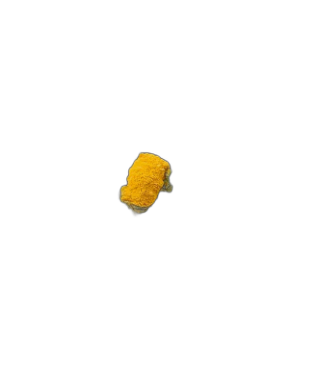

In [114]:
output = remove(image)
show_image(output)

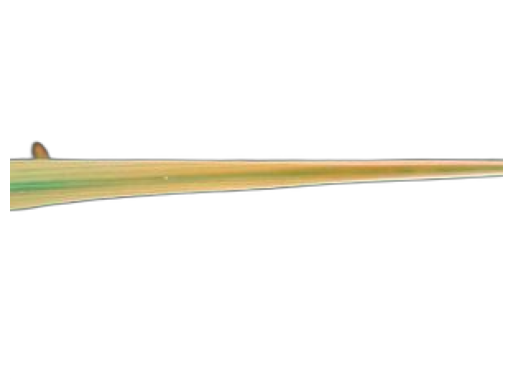

In [115]:
output = remove(image2)
show_image(output)

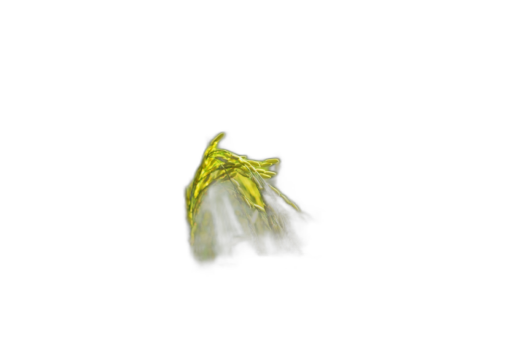

In [116]:
image4 = load_image('assets\healthy.jpeg')
output = remove(image4)
show_image(output)

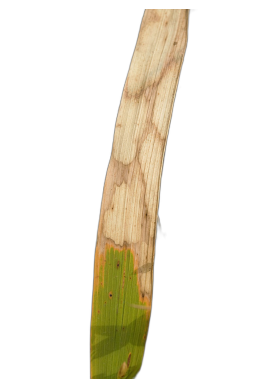

In [117]:
image3 = load_image('assets\sheath_blight.jpg')
output = remove(image3)
show_image(output)

In [140]:
def resize_removebg(path, width=224, height=224):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    no_bg = remove(image)
    # # Find the bounding box coordinates (non-zero pixels)
    non_zero_coords = np.argwhere(no_bg > 0)
    min_y, min_x, _ = non_zero_coords.min(axis=0)
    max_y, max_x, _ = non_zero_coords.max(axis=0)

    # # Crop the region to include only non-zero pixels
    cropped_region = no_bg[min_y:max_y + 1, min_x:max_x + 1]

    # # Optional: Resize the extracted region to a fixed size
    cropped_region = cv2.resize(cropped_region, (width, height))
    return cropped_region


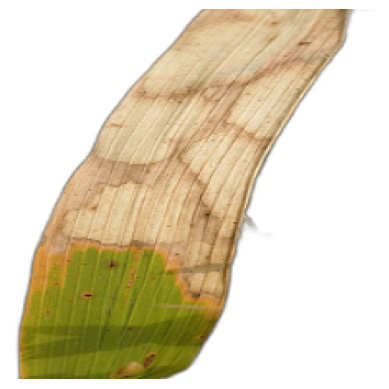

In [143]:
path = 'assets//sheath_blight.jpg'
test = resize_removebg(path)
show_image(test)

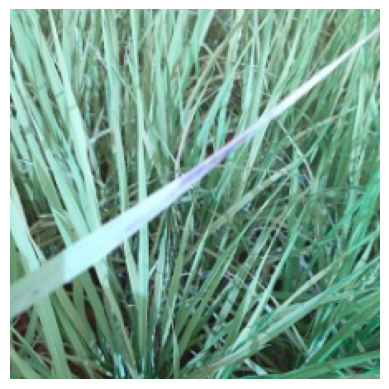

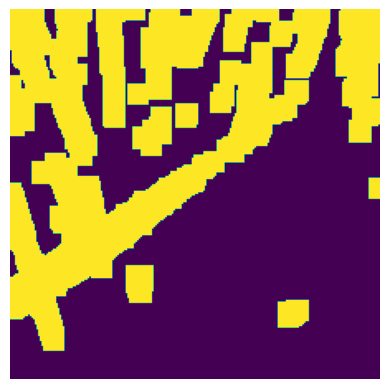

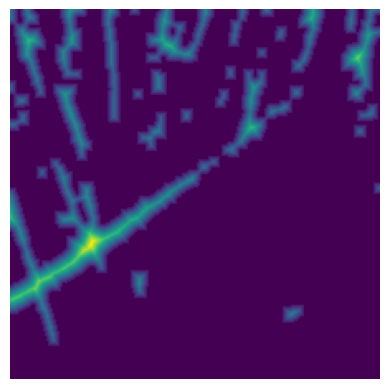

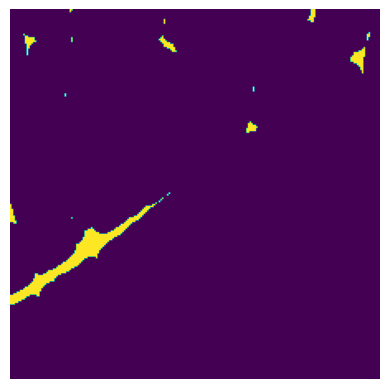

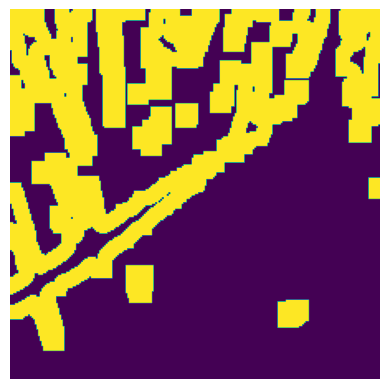

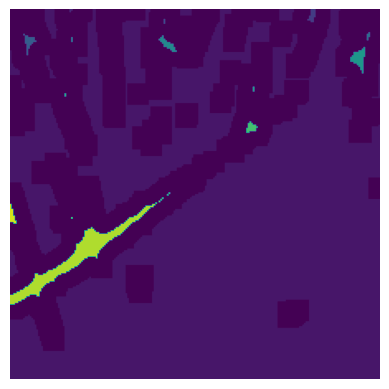

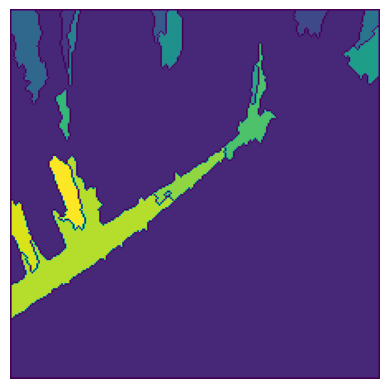

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\drawing.cpp:2537: error: (-215:Assertion failed) npoints > 0 in function 'cv::drawContours'


In [177]:
path = 'preprocessingData/bacterial_leaf_blight/BLB (137).png'

img = cv2.imread(path)
show_image(image)


#image grayscale conversion 
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 
# gray = hsv[:,:,1]

#Threshold Processing 
ret, bin_img = cv2.threshold(gray, 
                            0, 255,  
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU) 

# noise removal 
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)) 
bin_img = cv2.morphologyEx(bin_img,  
                        cv2.MORPH_OPEN, 
                        kernel, 
                        iterations=3) 

# Create subplots with 1 row and 2 columns 
# sure background area 
sure_bg = cv2.dilate(bin_img, kernel, iterations=3) 
show_image(sure_bg)

# Distance transform 
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 3) 
show_image(dist)

#foreground area 
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY) 
sure_fg = sure_fg.astype(np.uint8)   
show_image(sure_fg) 


# unknown area 
unknown = cv2.subtract(sure_bg, sure_fg) 
show_image(unknown)

plt.show()

# Marker labelling 
# sure foreground  
ret, markers = cv2.connectedComponents(sure_fg) 

# Add one to all labels so that background is not 0, but 1 
markers += 1
# mark the region of unknown with zero 
markers[unknown == 255] = 0

show_image(markers)


# watershed Algorithm 
markers = cv2.watershed(img, markers) 
 
show_image(markers)



labels = np.unique(markers) 

coins = [] 
# Iterate through the labels and process each one
for label in labels[2:]:
    # Create a binary image in which only the area of the label is in the foreground
    target = np.where(markers == label, 255, 0).astype(np.uint8)

    # Perform contour extraction on the created binary image
    _, contours = cv2.findContours(
        target, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # Check if there are any contours found
    if len(contours) > 0:
        # Draw the outline for each contour
        for contour in contours:
            if len(contour) > 0:  # Ensure that the contour is not empty
                img = cv2.drawContours(img, [contour], -1, color=(0, 23, 223), thickness=2)

show_image(img)



# img = cv2.imread("jpgData\9\9F--46-_jpg.rf.a10da8c992871ddc643e74e0bbe30c94.jpg")[100:300,100:300,:]
# rgb_planes = cv2.split(img)
# result_planes=[]
# for plane in rgb_planes:
#     plane = plane * (markers > 1)
#     result_planes.append(plane)
# result_image = cv2.merge(result_planes)
# result_image = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)
# plt.show_image(result_image)

# result_hsv = cv2.cvtColor(result_image, cv2.COLOR_RGB2HSV)


# fig, ax = plt.subplots(1,3, figsize=(15,4))
# ax[0].show_image(result_hsv[:,:,0]) #hue
# ax[0].set_title("HUE")
# ax[1].show_image(result_hsv[:,:,1]) #saturation
# ax[1].set_title("SATURATION")
# ax[2].show_image(result_hsv[:,:,2]) #value
# ax[2].set_title("VALUE")
# fig.suptitle("HSV Image")
# plt.show()

# Get unique labels/markers (excluding background and unknown)
unique_labels = np.unique(markers)[2:]

# Create a directory to save the extracted region images
# if not os.path.exists("segmented_regions"):
#     os.mkdir("segmented_regions")

# Extract and preprocess each segmented region
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
for label in unique_labels:
    # Create a binary mask for the specific label
    region_mask = np.where(markers == label, 255, 0).astype(np.uint8)

    # Apply the mask to the original image to extract the region
    region = cv2.bitwise_and(orig_img, orig_img, mask=region_mask)

    # # Find the bounding box coordinates (non-zero pixels)
    non_zero_coords = np.argwhere(region > 0)
    min_y, min_x, _ = non_zero_coords.min(axis=0)
    max_y, max_x, _ = non_zero_coords.max(axis=0)

    # # Crop the region to include only non-zero pixels
    cropped_region = region[min_y:max_y + 1, min_x:max_x + 1]

    # # Optional: Resize the extracted region to a fixed size
    cropped_region = cv2.resize(cropped_region, (128, 128))

    # Save the extracted and preprocessed region as a separate image
    plt.show_image(cropped_region)
    plt.show()
    '''
        Check if odd or even number of usable labels
        if odd: 
            add 1 to make even
        create base canvas
        divide area of base canvas based on num of labels
        resize labels to resulting area
        stich images to area incrementingly
        display image/save image
    '''
    # cv2.imwrite(image.replace(path,newPath,1).split('.')[0]+f"-region_{label}.png",region[:,:,1])

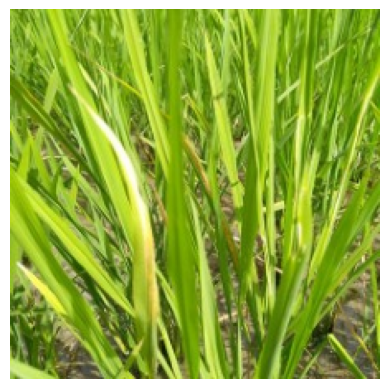

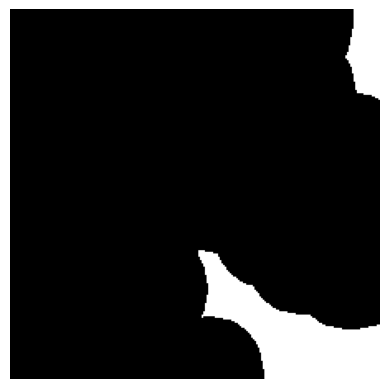

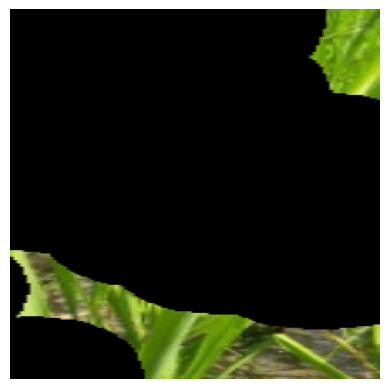

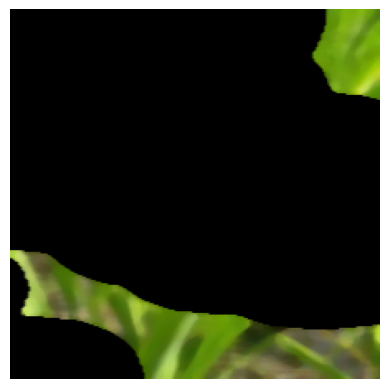

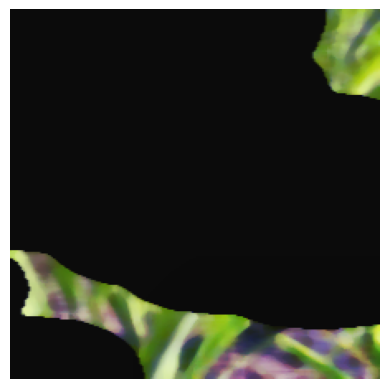

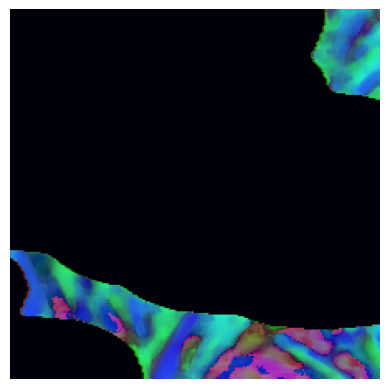

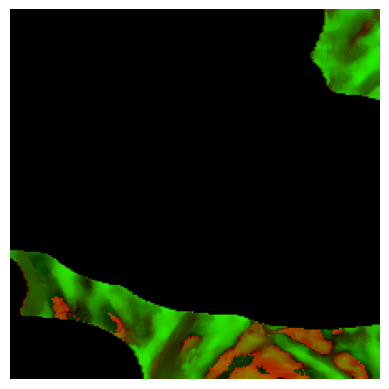

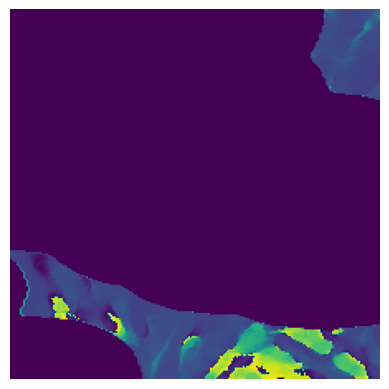

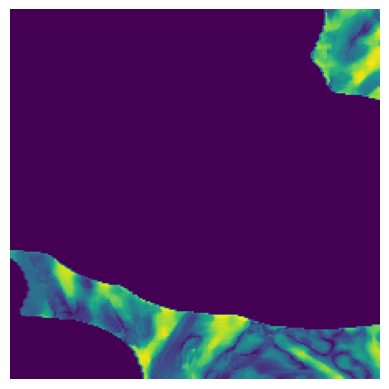

In [185]:


# Load image
img = load_image('preprocessingData/bacterial_leaf_blight/BLB (126).png')
show_image(img)
orig_img = img.copy()

gray = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2GRAY)

# Threshold Processing
ret, bin_img = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
bin_img = cv2.morphologyEx(bin_img, cv2.MORPH_OPEN, kernel, iterations=1)
bin_img = cv2.dilate(bin_img, kernel, iterations=3)

# Distance transform
dist = cv2.distanceTransform(bin_img, cv2.DIST_L2, 5)

# Foreground area
ret, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

plt.imshow(sure_fg, cmap='gray')
plt.axis('off')
plt.show()

# Apply the mask to the original image to extract the region
new_image_size= 224
region = cv2.bitwise_and(orig_img, orig_img, mask=sure_fg)

# Find the bounding box coordinates (non-zero pixels)
non_zero_coords = np.argwhere(region > 0)
min_y, min_x, _ = non_zero_coords.min(axis=0)
max_y, max_x, _ = non_zero_coords.max(axis=0)

# Crop the region to include only non-zero pixels
cropped_region = region[min_y:max_y + 1, min_x:max_x + 1]

cropped_region = cv2.resize(cropped_region, (new_image_size, new_image_size))

plt.imshow(cropped_region)
plt.axis('off')
plt.show()

rgb_planes = cv2.split(cropped_region)
result_planes = []

# Create a CLAHE object.
clahe = cv2.createCLAHE(tileGridSize=(3,3),clipLimit=10)
for plane in rgb_planes:
    processed_image = cv2.medianBlur(plane, 7)
    # processed_image = clahe.apply(processed_image) 
    result_planes.append(processed_image)

result = cv2.merge(result_planes)
plt.imshow(result)
plt.axis('off')
plt.show()

rgb_planes = cv2.split(result)
result_planes=[]
for plane in rgb_planes:
    # processed_image = cv2.medianBlur(plane, 7)
    processed_image = clahe.apply(plane) 
    result_planes.append(processed_image)

result = cv2.merge(result_planes)
plt.imshow(result)
plt.axis('off')
plt.show()

hsv = cv2.cvtColor(result,cv2.COLOR_RGB2HSV)
plt.imshow(hsv)
plt.axis('off')
plt.show()

h,s,v = cv2.split(hsv)
v *= 0
HS = cv2.merge([h,s,v])
plt.imshow(HS)
plt.axis('off')
plt.show()

H = hsv[:,:,0]
plt.imshow(H)
plt.axis('off')
plt.show()

S = hsv[:,:,1]
plt.imshow(S)
plt.axis('off')
plt.show()


# Saving 

In [188]:
import os
import shutil

## REPLACE FILE EXTENTION AND MOVE DATA
path = "RiceCrop_Disease_dataset"
dirs = [os.path.join(path,dir) for dir in os.listdir(path)]
classes = os.listdir(path)
newPath = 'preprocessingData'

for c in classes:
    classPath = os.path.join(newPath,c)
    if os.path.exists(classPath): shutil.rmtree(classPath); os.mkdir(classPath)
    else: os.mkdir(classPath)

oldImages = []
for dir in dirs:
    for image in os.listdir(dir):
        oldImages.append(os.path.join(dir,image))

for image in oldImages:
    shutil.copy(image, image.replace(path,newPath,1).replace("jpg","png").replace('jfif','png'))

In [ ]:
import os
import cv2
import shutil
from PIL import Image
from rembg import remove

## Variable Declerations
preprocessingPath="preprocessingData"
classes = os.listdir(preprocessingPath)
path = "dataset"
input_shape = (224,224) # changed from 224x224

## REMOVING BACKGROUND AND RETAINING SOIL
## RESIZING IMAGES FROM 416x416 to 224x224
## src: https://www.geeksforgeeks.org/how-to-remove-the-background-from-an-image-using-python/
  

# # CHECKS IF DATA DIRECTORIES EXISTS
# # DELETE IF SO, CREATE OTHERWISE
for c in classes:
    classPath = os.path.join(path,c)
    if os.path.exists(classPath): 
        shutil.rmtree(classPath); os.mkdir(classPath)
    else: 
        os.mkdir(classPath)

for c in classes:
    classPath = os.path.join(preprocessingPath,c)
    images = os.listdir(classPath)
    for image in images:
        imagePath = os.path.join(classPath,image)
  
        ## RESIZING IMAGE
        origImage = cv2.imread(imagePath)
        resizedImage = cv2.resize(origImage, input_shape, interpolation = cv2.INTER_NEAREST)
        cv2.imwrite(imagePath,resizedImage)

        # Processing the image
        input = Image.open(imagePath)
        
        # Removing the background from the given Image
        output = remove(input)
        
        #Saving the image in the given path
        output_path = imagePath.replace(preprocessingPath,path)
        output.save(output_path)

KeyboardInterrupt: 

In [189]:
import os
import cv2
import shutil
from PIL import Image
## Variable Declerations
preprocessingPath="preprocessingData"
classes = os.listdir(preprocessingPath)
path = "dataset"
input_shape = (224,224) # changed from 224x224

## REMOVING BACKGROUND AND RETAINING SOIL
## RESIZING IMAGES FROM 416x416 to 224x224
## src: https://www.geeksforgeeks.org/how-to-remove-the-background-from-an-image-using-python/
  

# # CHECKS IF DATA DIRECTORIES EXISTS
# # DELETE IF SO, CREATE OTHERWISE
for c in classes:
    classPath = os.path.join(path,c)
    if os.path.exists(classPath): 
        shutil.rmtree(classPath); os.mkdir(classPath)
    else: 
        os.mkdir(classPath)

for c in classes:
    classPath = os.path.join(preprocessingPath,c)
    images = os.listdir(classPath)
    for image in images:
        imagePath = os.path.join(classPath,image)
  
        ## RESIZING IMAGE
        origImage = cv2.imread(imagePath)
        resizedImage = cv2.resize(origImage, input_shape, interpolation = cv2.INTER_NEAREST)
        # cv2.imwrite(imagePath,resizedImage)

        # Processing the image
        resizedImage[:,:,1] *= 0
        
        # Removing the background from the given Image
        # output = remove(input)
        
        #Saving the image in the given path
        output_path = imagePath.replace(preprocessingPath,path)
        cv2.imwrite(output_path,resizedImage)

In [1]:
import os
import shutil
import numpy as np

## split data into train and test sets

preprocessingPath="preprocessingData"
path = "data"
classes = os.listdir(preprocessingPath)
trainPath = os.path.join(path,"train")
valPath = os.path.join(path,"val")
train = 0.80 # ;val = 1. - train
np.random.seed(26)

if os.path.exists(path): shutil.rmtree(path); os.mkdir(path)
else: os.mkdir(path)

for s in [trainPath, valPath]:
    if os.path.exists(s): shutil.rmtree(s); os.mkdir(s)
    else: os.mkdir(s)
    for c in classes:
        classPath = os.path.join(s,c)
        if os.path.exists(classPath): shutil.rmtree(classPath); os.mkdir(classPath)
        else: os.mkdir(classPath)

## SEPARATING TO TRAIN AND VALIDATION SETS
for c in classes:
    classPath = os.path.join(preprocessingPath,c)
    images = np.array(os.listdir(classPath))
    np.random.shuffle(images)
    numImages = len(images)
    setClassPath = os.path.join(trainPath,c)
    for n,image in enumerate(images):
        if n == round(numImages*train): 
            setClassPath = os.path.join(valPath,c)
        imagePath = os.path.join(classPath,image)
        newImagePath = os.path.join(setClassPath,image)
        shutil.copy(imagePath, newImagePath)